In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import TensorFlow modules (edit this list if needed)
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.applications import VGG16

2024-01-10 11:39:41.997774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 11:39:42.093488: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 11:39:42.097083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-10 11:39:42.097092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

TensorFlow version: 2.10.0


## Data processing

In [3]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

Fichier ‘/tmp/cats_and_dogs_filtered.zip’ déjà présent ; pas de récupération.
Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.721.jpg', 'cat.965.jpg', 'cat.229.jpg', 'cat.337.jpg', 'cat.594.jpg', 'cat.445.jpg', 'cat.44.jpg', 'cat.883.jpg', 'cat.490.jpg', 'cat.499.jpg']
['dog.494.jpg', 'dog.619.jpg', 'dog.306.jpg', 'dog.558.jpg', 'dog.364.jpg', 'dog.517.jpg', 'dog.543.jpg', 'dog.780.jpg', 'dog.971.jpg', 'dog.731.jpg']


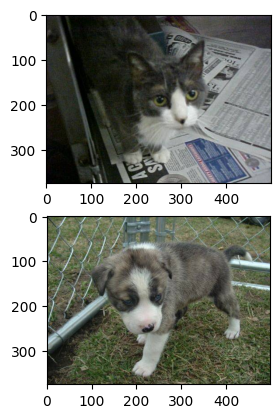

In [4]:
from PIL import Image

img = np.asarray(Image.open(os.path.join(train_cats_dir,train_cat_fnames[0])))
plt.figure(1)
plt.subplot(211)
plt.imshow(img)

img = np.asarray(Image.open(os.path.join(train_dogs_dir,train_dog_fnames[0])))
plt.subplot(212)
plt.imshow(img)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            seed=42,
                                                            batch_size=16,
                                                          label_mode='binary',
                                                          image_size=(128, 128))

valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                            shuffle=True,
                                                            seed=42,
                                                            batch_size=16,
                                                          label_mode='binary',
                                                          image_size=(128, 128))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


2024-01-10 11:39:43.901133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-10 11:39:43.901154: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-10 11:39:43.901168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Albert): /proc/driver/nvidia/version does not exist
2024-01-10 11:39:43.901442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training

In [6]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""
    loss = history.history['loss']
    acc = history.history['accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

    plt.tight_layout()

In [7]:
from keras.applications import vgg16
modelVGG = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))

for layer in modelVGG.layers:
    layer.trainable = False
modelVGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [8]:
entireModel = Sequential()
entireModel.add(modelVGG)
entireModel.add(Flatten())
entireModel.add(Dense(128, activation='relu'))
entireModel.add(Dense(32, activation='relu'))
entireModel.add(Dense(16, activation='relu'))
entireModel.add(Dense(8, activation='relu'))
entireModel.add(Dense(1, activation='sigmoid'))

entireModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9

Epoch 1/5
125/125 [==============================] - 131s 1s/step - loss: 0.5907 - accuracy: 0.8070 - val_loss: 0.3680 - val_accuracy: 0.8730
Epoch 2/5
125/125 [==============================] - 139s 1s/step - loss: 0.1174 - accuracy: 0.9580 - val_loss: 0.3179 - val_accuracy: 0.9020
Epoch 3/5
125/125 [==============================] - 137s 1s/step - loss: 0.0436 - accuracy: 0.9870 - val_loss: 0.3170 - val_accuracy: 0.9050
Epoch 4/5
125/125 [==============================] - 136s 1s/step - loss: 0.0233 - accuracy: 0.9955 - val_loss: 0.3322 - val_accuracy: 0.9130
Epoch 5/5
125/125 [==============================] - 136s 1s/step - loss: 0.0114 - accuracy: 0.9980 - val_loss: 0.3354 - val_accuracy: 0.9100


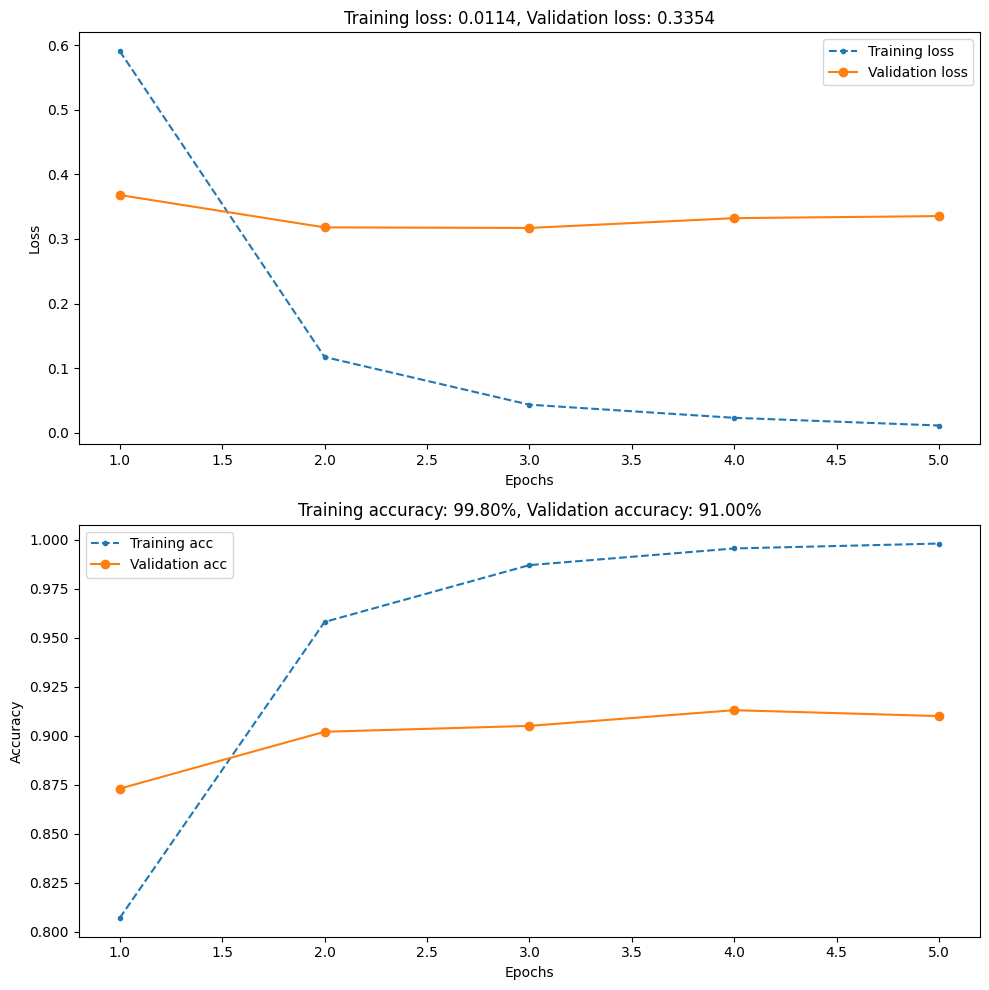

In [9]:
entireModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = entireModel.fit(train_dataset, epochs=5, validation_data=valid_dataset)
plot_loss_acc(history)

In [10]:
!mkdir -p saved_model
entireModel.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


## LIME

In [11]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [12]:
entireModel = tf.keras.models.load_model('saved_model/my_model')

In [13]:
explainer = lime_image.LimeImageExplainer()

In [14]:
images, labels = tuple(zip(*valid_dataset))

images = np.array(images)
labels = np.array(labels)

/tmp/ipykernel_19429/957287225.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)
/tmp/ipykernel_19429/957287225.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.array(labels)


[1.]
1/1 [==============================] - 1s 824ms/step
[0.9997195]


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 489ms/step


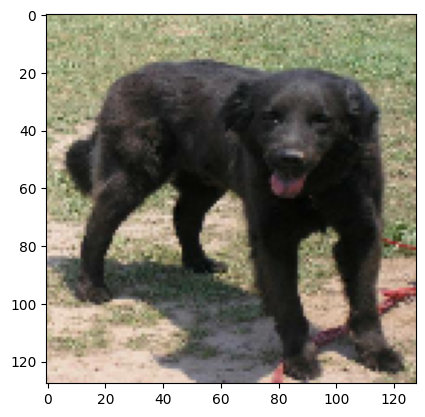

In [15]:
dataset_size = valid_dataset.cardinality().numpy()
rand_idx = np.random.randint(0, 16)

explanation = None
for image, label in valid_dataset.take(1):
    img = image[rand_idx].numpy().astype("uint8")
    plt.imshow(img)
    print (label[rand_idx].numpy())
    out = entireModel.predict(image)
    print(out[rand_idx])
    explanation = explainer.explain_instance(img, entireModel.predict, top_labels=2, hide_color=0, num_samples=100)
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=num_fe, hide_rest=False)
#     plt.imshow(mark_boundaries(temp, mask))

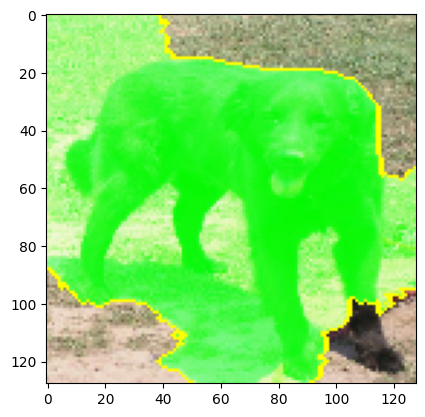

In [16]:
num_features = 5
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=num_features, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

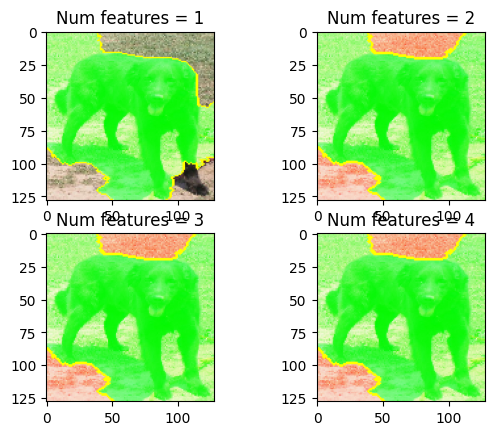

In [32]:
for i in range(1,5):
    num_features = 5*i
#     plt.figure(figsize=(5,5))
    plt.subplot(2,2,i)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=num_features, hide_rest=False)
    plt.title("Num features = "+str(i))
    plt.imshow(mark_boundaries(temp, mask))
